In [1]:
import xarray as xr
import xroms
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import pandas as pd

# How to calculate with `xarray` and `xroms`

Here we demonstrate a number of calculations built into `xroms`, through accessors to `DataArrays` and `Datasets`.

## `xarray` Datasets
Use an `xarray` accessor in `xroms` to easily perform calculations with syntax 

    ds.xroms.[method]
    
Importantly, the `xroms` accessor to a `Dataset` is initialized with an `xgcm` grid object, stored at `ds.xroms.grid`, which is used to perform the basic grid calculations. More on this under "How to set up grid" below.

Generally the built-in calculations take in the horizontal then vertical grid label you want the calculation to be on as options:

    ds.xroms.dudz('rho', 's_rho')  # to make sure result is on rho horizontal grid and s_rho vertical grid
    
or

    ds.xroms.dudz()  # return on whatever grid it is calculated on
    
These are not stored as properties in the accessor since they depend on the user's choice of grids, but since they are lazily evaluated, they are quick to rerun as needed.

Other inputs are available for functions when the calculation involves a derivative and there is a choice for how to treat the boundary (`hboundary` and `hfill_value` for horizontal calculations and `sboundary` and `sfill_value` for vertical calculations). More information on those inputs can be found in the docs for `xgcm` such as under found under:

    ds.xroms.grid.interp?


### `xarray` DataArrays

A few of the more basic methods in `xroms` are available to `DataArrays` too. Unlike a `Dataset` in `xroms`, a `DataArray` does not know about its grid (a `Dataset` has its grid information stored in `ds.xroms.grid`). So, the built-in `xroms` methods for `DataArrays` require the grid object to be input.

    ds.temp.xroms.to_grid(ds.xroms.grid, hcoord='psi', scoord='s_w')

### Load in data

More information at in [load_data notebook](load_data.ipynb)

In [2]:
# loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/forecast_latest/txla2_his_f_latest.nc'
# chunks = {'ocean_time':1}
# ds = xroms.open_netcdf(loc, chunks=chunks)  # also adds z coordinates
loc = 'txla2_his_a_latest.nc'
chunks = {'ocean_time': 1} #{'s_rho': 1}
ds = xroms.open_netcdf(loc, chunks='auto')

## `xgcm` grid and extra ROMS coordinates

### How to set up grid

The package `xcgm` has many nice grid functions for ROMS users, however, a bit of set up is required to connect from ROMS to MITgcm output. This grid set up does that.

The `grid` object contains metrics (X, Y, Z) with distances for each grid ('dx', 'dx_u', 'dx_v', 'dx_psi', and 'dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v', 'dz_psi', 'dz_w_psi'), and all of these as grid coordinates too. 

Coordinates are added to the dataset when `xroms.open_netcdf` or `xroms.open_zarr` are used. The grid object is read into the `xroms` accessor and saved in the location `ds.xroms.grid`.

You can also explicitly set up the grid with:

> ds, grid = xroms.roms_dataset(ds)

This process sets up all sorts of useful coordinate variables, including a grid called `verts` which is if the `psi` grid had another row or column on each side of the domain and is useful for plotting a rho grid-based variable in pcolormesh.

### Grid lengths

Distances between grid nodes on every ROMS grid are calculated in the setup process using `xroms` (that is, by reading in your output using as `xroms` load function or subsequently running `xroms.roms_dataset`). 

* Horizontal grids:
 * distances between nodes are given in projected coordinates (should be meters but could depend on your projection) by dx's and dy's stored in ds, such as: `ds.dx` for the `rho` grid and `ds.dy_psi` for the `psi` grid
 * inverse distances between nodes are also given in an analogous way (*i.e.*, `ds.pm` and `ds.pn_psi`)
* Vertical grids:
 * There are z-coordinates for both `rho` and `w` vertical grids for each horizontal grid calculated lazily.
 * There are also arrays of z distances between nodes, called dz's, available for each combination of grids. For example, there is `ds.dz_u` for z distances on the `u` horizontal and `rho` vertical grid, and there is `ds.dz_w_v` for z distances on the `v` horizontal and `w` vertical grid. These are `[ocean_time x s_* x eta_* x xi_*]` arrays.
 * Arrays of z distances relative to a sea level of 0 are also available. They have analogous names to the previous entries but with "0" on the end. They are computationally faster to use because they do not vary in time. They are also less accurate for this reason but it depends on your use as to how much that matters.

### Grid areas

* Horizontal
  * rho grid `ds.dA`, psi grid `ds.dA_psi`, u grid `ds.dA_u`, v grid `ds.dA_v`
* Vertical
  * These aren't built in but can easily be calculated. For example, for cell areas in the x direction on the rho horizontal and rho vertical grids: `ds.dx * ds.dz`.

### Grid volumes

Time varying: All 8 combinations of 4 horizontal grids and 2 vertical grids are available, such as: `ds.dV` (rho horizontal, rho vertical), and `ds.dV_w_v` (w vertical, v horizontal). 

A user can easily calculate the same but for time-constant dz's, for example as: 

    ds['dV_w'] = ds.dx * ds.dy * ds.dz_w0  # w vertical, rho horizontal, constant in time

## Change grids

A ROMS user frequently needs to move between horizontal and vertical grids, so it is built into many of the function wrappers, but you can also do it as a separate function. It can also be done to both `Datasets` and `DataArrays` with slightly different syntax. Here we change salinity from its default grids to be on the psi grid horizontally and the s_w grid vertically:

In [3]:
ds.xroms.to_grid('salt', 'psi', 's_w');   # Dataset
ds.salt.xroms.to_grid(ds.xroms.grid, 'psi', 's_w');   # DataArray

You can also go to the original `xroms` function and avoid the `xarray` accessor if you prefer, though the point of the accessor approach (that is, `ds.xroms...`) is to be easier to remember and less code to write generally.

In [4]:
xroms.to_grid(ds.salt, ds.xroms.grid, 'psi', 's_w');

## Basic `xarray` computations

Many [computations](http://xarray.pydata.org/en/stable/computation.html) are built into `xarray` itself. Often it is possible to input the dimension over which to perform a computation by name, such as:

    arr.sum(dim="xi_rho")

or 

    arr.sum(dim=("xi_rho","eta_rho"))

Note that many basic `xarray` calculations should be used with caution when using with ROMS output, since a ROMS grid can be stretched both horizontally and vertically. When using these functions, consider if your calculation should account for variable grid cell distances, areas, or volumes. Additionally, it is straight-forward to use basic grid functions from `xarray` on a ROMS time dimension (resampling, differentiation, interpolation, etc), however, be careful before using these functions on spatial dimensions for the same reasons as before.

In [6]:
ds.salt.mean(dim=("xi_rho","eta_rho"))

<xarray.DataArray 'salt' (ocean_time: 24, s_rho: 30)>
dask.array<mean_agg-aggregate, shape=(24, 30), dtype=float32, chunksize=(24, 30), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-10-31

## Derivatives

### Vertical

In [5]:
ds.xroms.ddz('salt');  # Dataset

In [6]:
ds.salt.xroms.ddz(ds.xroms.grid);  # DataArray

In [7]:
xroms.ddz(ds.salt, ds.xroms.grid);  # No accessor

There are more options available for this call:

In [8]:
ds.xroms.ddz('salt', 'dsaltdz', hcoord='psi', scoord='s_rho', sboundary='extend', sfill_value=np.nan);  # Dataset

In [9]:
ds.salt.xroms.ddz(ds.xroms.grid, 'dsaltdz', hcoord='psi', scoord='s_rho', sboundary='extend', sfill_value=np.nan);  # DataArray

In [10]:
xroms.ddz(ds.salt, ds.xroms.grid, 'dsaltdz', hcoord='psi', scoord='s_rho', sboundary='extend', sfill_value=np.nan);  # No accessor

### Horizontal

In [3]:
ds.xroms.ddxi('u');  # horizontal xi-direction gradient
ds.xroms.ddeta('u');  #  horizontal eta-direction gradient

### Time

In [27]:
ddt = ds.chunk({'ocean_time': 2}).differentiate('ocean_time', datetime_unit='s')

## Built-in Physical Calculations

### Horizontal speed

In [4]:
ds.xroms.speed();

### Kinetic energy

In [3]:
ds.xroms.KE();

### Vertical shear

Since it is a common use case, there are specific methods to return the u and v components of vertical shear on their own grids, as follows, and note that as always these functions will take in `hcoord` and `scoord` to shift grids. These are just available for Datasets.

In [11]:
ds.xroms.dudz();  

In [12]:
ds.xroms.dvdz();

If we want to calculate something with both, we need them on the same grid. For this, we can input the desired resultant grid:

In [13]:
ds.xroms.dudz(hcoord='rho', scoord='s_rho')**2 + ds.xroms.dvdz(hcoord='rho', scoord='s_rho')**2;

### density

In [4]:
ds.xroms.rho();

### potential density

In [ ]:
ds.xroms.sig0();

### buoyancy frequency (vertical buoyancy gradient)

In [15]:
ds.xroms.N2(hcoord=None, scoord='s_w', sboundary='fill', sfill_value=np.nan);

### horizontal buoyancy gradient 

In [ ]:
ds.xroms.M2(hcoord=None, scoord='s_w', sboundary='fill', sfill_value=np.nan);

### vertical vorticity

In [16]:
ds.xroms.vort();

### ertel

In [17]:
ds.xroms.ertel();

### mixed layer depth

In [4]:
ds.xroms.mld();

## Time-based calculations

### Resampling in time

Can't have any chunks in the time dimension to do this. More info: http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html

#### Upsample

Makes sense to interpolate to fill in data when upsampling, but can also forward or backfill, or just add nan's.

In [47]:
dstest = ds.resample(ocean_time='30min').interpolate()

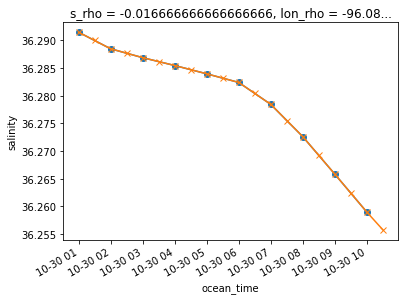

In [49]:
ds.salt.xroms.isel(eta=30, xi=20, s=-1, t=slice(0,10)).plot(marker='o')
dstest.salt.xroms.isel(eta=30, xi=20, s=-1, t=slice(0,20)).plot(marker='x')


#### Downsample

Resample down to lower resolution in time. This requires appending a method to aggregate the extra data, such as a `mean`. Note that other options can be used to shift the result within the interval of aggregation in various ways.

In [56]:
dstest = ds.resample(ocean_time='3H').mean()

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


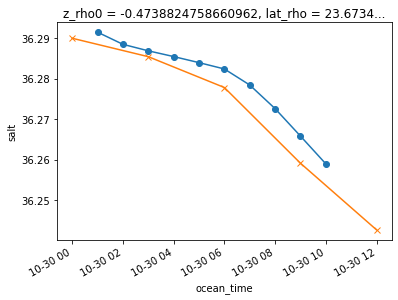

In [57]:
ds.salt.xroms.isel(eta=30, xi=20, s=-1, t=slice(0,10)).plot(marker='o')
dstest.salt.xroms.isel(eta=30, xi=20, s=-1, t=slice(0,5)).plot(marker='x')


### Rolling averages in time

Here is an example of computing a rolling average in time.

More information about rolling operations [is available](http://xarray.pydata.org/en/stable/computation.html#rolling-window-operations).

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


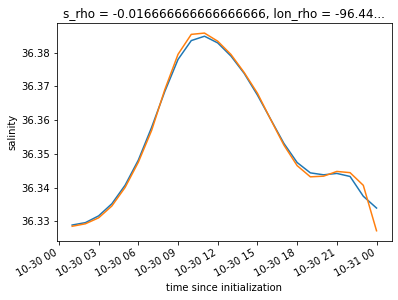

In [15]:
roll = ds.salt.rolling(ocean_time=3, center=True, min_periods=2).mean()
roll.isel(s_rho=-1, eta_rho=50, xi_rho=40).plot()
ds.salt.isel(s_rho=-1, eta_rho=50, xi_rho=40).plot()


## Climatologies

### Seasonal average, over time

This is an example of [resampling](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html).

The result of this calculation is a time series of quarterly means of model output. Here we use a long time series model as the example to better demonstrate.

Resampling can take in strings like:
* "QS": quarters, starting in January of each year and averaging three months.
  * Also available are selections like "QS-DEC", quarters but starting with December to better align with seasons. Other months are input options as well.
* "MS": monthly
* "D": daily
* Many more options are given [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

After the `resampling` call, some aggregator must be appended to combine the data in some way. `mean` is demonstrated below but `max`, `min`, and `std` might also be useful.

In [82]:
loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/NcML/txla_hindcast_agg'
ds = xroms.open_netcdf(loc, chunks='auto')

In [87]:
qs = ds.salt.resample(ocean_time="QS-DEC").mean()
qs.ocean_time

### Seasonal mean over all available time

This is how to average over the full dataset period by certain times, in this case we show the seasonal mean averaged across the full model time period. Use `groupby` to do this.

Other time options include:
* "ocean_time.month"
* "ocean_time.dayofyear"
* other options you might expect from Pandas. More information about options for time (including "derived" datetime coordinates) is [here](https://xarray.pydata.org/en/v0.16.0/time-series.html#datetime-components).


In [90]:
qs2 = ds.groupby('ocean_time.season').mean('ocean_time')
qs2.salt

<xarray.DataArray 'salt' (season: 4, s_rho: 30, eta_rho: 191, xi_rho: 671)>
dask.array<concatenate, shape=(4, 30, 191, 671), dtype=float32, chunksize=(1, 30, 103, 61), chunktype=numpy.ndarray>
Coordinates:
    z_rho0   (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(30, 191, 671), meta=np.ndarray>
    lat_rho  (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lon_rho  (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
  * s_rho    (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.08333 -0.05 -0.01667
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: eta_rho, xi_rho